# 05 — AI-Assisted Segmentation & Narrative Margin Insights

**Goal.** Analyse shipment- and charge-level behaviour to identify client/supplier
segments, understand margin patterns, and generate AI-powered narrative insights
for decision-makers.

This notebook demonstrates how **traditional analytics (clustering)** and
**modern LLMs (OpenAI Responses API)** can work together to support commercial,
pricing, and supplier relationship decisions in a 3PL environment.

**Key outputs:**
- Client-level behavioural dataset (margin %, loss rate, charge mix).
- KMeans segmentation into meaningful behavioural clusters.
- Human-readable cluster profiles.
- LLM-generated narrative insights (optional if API credits available).

In [5]:
# Standard libraries
import os
from pathlib import Path

# Data / ML
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Plotting visuals
import matplotlib.pyplot as plt
import seaborn as sns

# OpenAI (AI narrative)
try:
    from openai import OpenAI
    client = OpenAI()
    OPENAI_ENABLED = True
except Exception as e:
    print("⚠️ OpenAI not enabled:", e)
    OPENAI_ENABLED = False

# Paths
PROJECT_ROOT = Path(".").resolve()
DATA_DIR = PROJECT_ROOT / ".." / "data"   

In [6]:
# Load pre-cleaned facts
df_ship = pd.read_parquet(DATA_DIR / "fct_shipments_randomised.parquet")
df_chg  = pd.read_parquet(DATA_DIR / "fct_charges_randomised.parquet")

# Add margin columns to shipment table BEFORE merge
df_ship["margin"] = df_ship["total_sales"] - df_ship["total_costs"]
df_ship["margin_pct"] = np.where(
    df_ship["total_sales"] != 0,
    df_ship["margin"] / df_ship["total_sales"] * 100,
    np.nan
)

# Merge to create the expanded model
df = df_ship.merge(df_chg, on="unique_tracking", how="left")

In [7]:
client_agg = (
    df_ship.groupby("client_code", as_index=False)
    .agg(
        shipments=("unique_tracking", "nunique"),
        total_revenue=("total_sales", "sum"),
        total_cost=("total_costs", "sum"),
        loss_shipments=("is_loss_making", "sum"),
    )
)

# Derived metrics
client_agg["margin"] = client_agg["total_revenue"] - client_agg["total_cost"]
client_agg["margin_pct"] = client_agg["margin"] / client_agg["total_revenue"].replace(0, np.nan)
client_agg["loss_rate"] = client_agg["loss_shipments"] / client_agg["shipments"].replace(0, np.nan)

client_agg.head()

,client_code,shipments,total_revenue,total_cost,loss_shipments,margin,margin_pct,loss_rate
0,CLIENT001,1441104,9911326.24,6706964.53,17265,3204361.71,0.323303,0.011980
1,CLIENT002,1154664,7879908.20,5341195.06,13797,2538713.14,0.322175,0.011949
2,CLIENT003,964276,6578728.12,4463901.58,11351,2114826.54,0.321464,0.011772
3,CLIENT004,675571,4629537.25,3136407.97,7961,1493129.28,0.322522,0.011784
4,CLIENT005,578874,3940545.94,2681112.68,6739,1259433.26,0.319609,0.011642


In [8]:
# Pivot charge lines into wide features per client
charge_mix = (
    df.groupby(["client_code", "charge_type"])
    .size()
    .unstack(fill_value=0)
)

# Merge into main client dataframe
client_features = client_agg.merge(charge_mix, on="client_code", how="left").fillna(0)

client_features.head()

,client_code,shipments,total_revenue,total_cost,loss_shipments,margin,margin_pct,loss_rate,Collection_Fee,Customs_Clearance,Delivery_Attempt,Duty_Handling,Fuel_Surcharge,Insurance,Oversize,Peak_Surcharge,Remote_Area,Saturday_Delivery
0,CLIENT001,1441104,9911326.24,6706964.53,17265,3204361.71,0.323303,0.011980,636978,636581,637194,637373,636505,635796,636770,636554,637047,636666
1,CLIENT002,1154664,7879908.20,5341195.06,13797,2538713.14,0.322175,0.011949,510114,508753,509572,508564,508726,509124,509163,510358,509558,509993
2,CLIENT003,964276,6578728.12,4463901.58,11351,2114826.54,0.321464,0.011772,423623,424555,424765,425271,424969,424885,424659,424763,424684,424099
3,CLIENT004,675571,4629537.25,3136407.97,7961,1493129.28,0.322522,0.011784,297717,297976,297766,297156,297992,298063,297390,297569,296998,297699
4,CLIENT005,578874,3940545.94,2681112.68,6739,1259433.26,0.319609,0.011642,255105,254102,254911,255025,254961,255087,254921,254233,254301,254521


In [9]:
# Core behavioural features
base_features = [
    "shipments",
    "total_revenue",
    "margin_pct",
    "loss_rate"
]

X = client_features[base_features].fillna(0)

# Scaling for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
k = 4  # can tune later
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
client_features["cluster"] = kmeans.fit_predict(X_scaled)

client_features["cluster"].value_counts()

c:\Users\lewis\miniconda3\envs\plac_portfolio\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
c:\Users\lewis\miniconda3\envs\plac_portfolio\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


cluster
1    14
0     4
2     3
3     1
Name: count, dtype: int64

In [11]:
cluster_summary = (
    client_features.groupby("cluster")
    .agg(
        clients=("client_code", "nunique"),
        shipments=("shipments", "sum"),
        total_revenue=("total_revenue", "sum"),
        avg_margin_pct=("margin_pct", "mean"),
        avg_loss_rate=("loss_rate", "mean"),
    )
    .reset_index()
)

cluster_summary

,cluster,clients,shipments,total_revenue,avg_margin_pct,avg_loss_rate
0,0,4,869595,6014181.66,0.321886,0.012110
1,1,14,5018098,34212421.63,0.322042,0.011692
2,2,3,3560044,24369962.56,0.322314,0.011900
3,3,1,193268,1276291.65,0.328279,0.011342


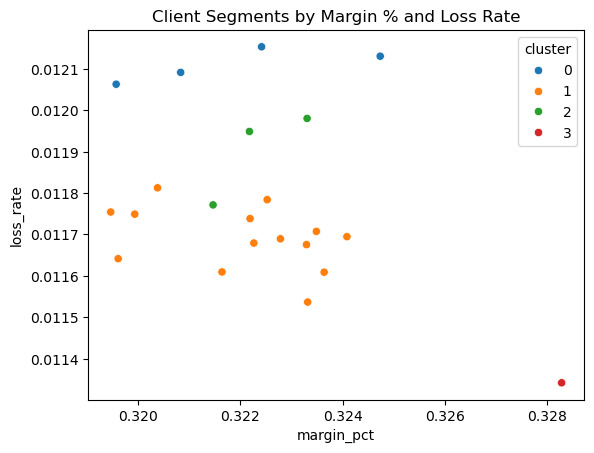

In [12]:
sns.scatterplot(
    data=client_features,
    x="margin_pct",
    y="loss_rate",
    hue="cluster",
    palette="tab10"
)
plt.title("Client Segments by Margin % and Loss Rate")
plt.show()

In [14]:
def build_cluster_profile(cid):
    row = cluster_summary.loc[cluster_summary["cluster"] == cid].iloc[0]

    sample_clients = (
        client_features[client_features["cluster"] == cid]
        .sort_values("total_revenue", ascending=False)
        .head(5)[["client_code", "shipments", "total_revenue", "margin_pct", "loss_rate"]]
    )

    profile = f"""
Cluster {cid} Overview
----------------------
Clients: {int(row.clients)}
Total Revenue: £{row.total_revenue:,.0f}
Average Margin %: {row.avg_margin_pct:.2%}
Average Loss Rate: {row.avg_loss_rate:.2%}

Top Example Clients:
{sample_clients.to_markdown(index=False)}
"""
    return profile

print(build_cluster_profile(0))


Cluster 0 Overview
----------------------
Clients: 4
Total Revenue: £6,014,182
Average Margin %: 32.19%
Average Loss Rate: 1.21%

Top Example Clients:
| client_code   |   shipments |    total_revenue |   margin_pct |   loss_rate |
|:--------------|------------:|-----------------:|-------------:|------------:|
| CLIENT009     |      386878 |      2.66807e+06 |     0.320831 |   0.0120917 |
| CLIENT015     |      193731 |      1.36221e+06 |     0.31957  |   0.0120631 |
| CLIENT013     |      192537 |      1.31319e+06 |     0.322413 |   0.0121535 |
| CLIENT019     |       96449 | 670707           |     0.324732 |   0.0121308 |



In [15]:
def generate_cluster_narrative(profile_text):
    if not OPENAI_ENABLED:
        return "⚠️ OpenAI disabled or no credits available."

    response = client.responses.create(
        model="gpt-4.1-mini",
        input=f"""
You are a commercial analyst in a 3PL business.
Based on the cluster profile below, generate:
- A clear behavioural explanation of the segment
- 3–5 recommended commercial actions
- 2 risks to monitor

Cluster Profile:
{profile_text}
"""
    )
    return response.output[0].content[0].text

# generate_cluster_narrative(build_cluster_profile(0))

In [16]:
def generate_exec_summary(cluster_summary):
    if not OPENAI_ENABLED:
        return "⚠️ OpenAI disabled — will generate after credits are enabled."

    summary_text = cluster_summary.to_markdown(index=False)

    response = client.responses.create(
        model="gpt-4.1-mini",
        input=f"""
Write a concise executive summary for senior leadership based on this cluster table:

{summary_text}

Focus on: revenue concentration, margin risks, operational insights.
"""
    )
    return response.output[0].content[0].text

# Conclusion

This notebook integrates:
- **Data engineering** (feature creation from shipment & charge-level data),
- **Unsupervised ML** (KMeans clustering),
- **Commercial analysis** (cluster behaviour, margin patterns),
- **AI-powered narrative** (automated commentary & recommendations).

In a real 3PL environment, these insights can guide:
- margin protection actions,
- pricing strategy,
- supplier conversations,
- client portfolio management,
- operational improvements.

This notebook forms part of a broader advanced analytics portfolio.